In [28]:
print('hello world')

hello world


In [29]:
import sys
sys.path.append('/home/s94zalek/shape_matching')

# set logging level to info
import logging
logging.basicConfig(level=logging.INFO)

from datasets_code import build_dataloader, build_dataset
from utils.options import parse_options
from train import create_train_val_dataloader
import torch
import numpy as np

import os
os.chdir('/home/s94zalek/shape_matching')

# print current working directory
print(os.getcwd())

/home/s94zalek/shape_matching


In [ ]:
import os

# root_path = osp.abspath(osp.join(__file__, osp.pardir))
root_path = '/home/s94zalek/shape_matching'

opt = parse_options(root_path, is_train=False, use_argparse=False,
                    opt_path = 'options/train/faust.yaml')

opt['root_path'] = root_path
opt['dist'] = False

opt['datasets']['train_dataset']['return_corr'] = True
opt['datasets']['train_dataset']['return_dist'] = False
opt['datasets']['test_dataset']['return_dist'] = False

# create train and validation dataloaders
result = create_train_val_dataloader(opt)
train_loader, train_sampler, val_loader, total_epochs, total_iters = result
train_dataset = train_loader.dataset

test_set = build_dataset(opt['datasets']['test_dataset'])
test_loader = build_dataloader(
test_set, opt['datasets']['test_dataset'], phase='val', num_gpu=opt['num_gpu'], dist=opt['dist'], sampler=None, seed=opt['manual_seed'])


Backend DataParallel.
Path already exists. Rename it to /home/s94zalek/shape_matching/results/faust_archived_20240513_101613


Calculating functional maps: 100%|█████████████████████████████████████████████████████████████████████████████████| 6400/6400 [01:31<00:00, 69.81it/s]
2024-05-13 10:18:08,437 INFO: Dataset [PairFaustDataset]-[FaustTrain] is built.
Calculating functional maps: 100%|██████████████████████████████████████████████████████████████████████████████████| 400/400 [00:03<00:00, 102.12it/s]
2024-05-13 10:18:15,886 INFO: Dataset [PairFaustDataset]-[FaustTest] is built.
Calculating functional maps: 100%|██████████████████████████████████████████████████████████████████████████████████| 400/400 [00:03<00:00, 104.32it/s]
2024-05-13 10:18:20,353 INFO: Dataset [PairFaustDataset]-[FaustTest] is built.


In [89]:
import torch

data = train_dataset[32]
data_x = data['first']
data_y = data['second']

# indices = torch.randperm(min(
#     data_x['evecs'].shape[0],
#     data_y['evecs'].shape[0],
#     ))[:150]
indices = list(range(100))

Cxy_reduced_100 = torch.linalg.lstsq(
    data_y['evecs'][data_y['corr']][indices, :],
    data_x['evecs'][data_x['corr']][indices, :]
    ).solution
Cyx_reduced_100 = torch.linalg.lstsq(
    data_x['evecs'][data_x['corr']][indices, :],
    data_y['evecs'][data_y['corr']][indices, :]
    ).solution

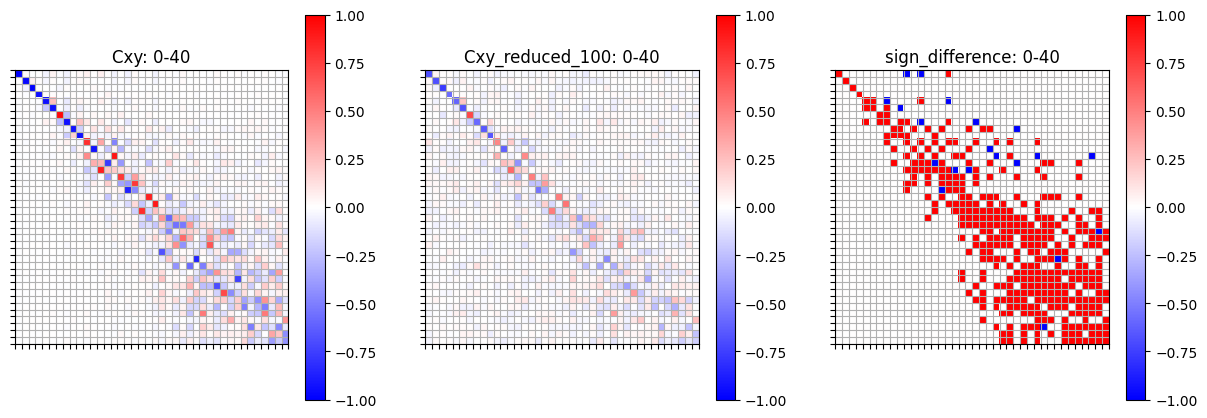

In [90]:
import matplotlib.pyplot as plt

def plot_Cxy(figure, axis, Cxy_plt, title, min_dim, max_dim):
    
    axis_plot = axis.imshow(Cxy_plt[min_dim:max_dim, min_dim:max_dim], cmap='bwr', vmin=-1, vmax=1)
    figure.colorbar(axis_plot, ax=axis)
    
    axis.set_title(f'{title}: {min_dim}-{max_dim}')

    axis.set_xticks(np.arange(-0.5, max_dim - min_dim, 1.0))
    axis.set_yticks(np.arange(-0.5, max_dim - min_dim, 1.0))     
    axis.grid(which='both')
    
    axis.set_xticklabels([])
    axis.set_yticklabels([])
   


def get_sign_difference(Cxy_gt, Cxy_target, threshold):
    Cxy_signs = torch.sign(Cxy_gt)
    Cxy_target_signs = torch.sign(Cxy_target)

    Cxy_nonzero = (Cxy_gt.abs() > threshold).int()
    # print
    sign_difference = Cxy_signs * Cxy_target_signs * Cxy_nonzero

    return sign_difference


fig, ax = plt.subplots(1, 3, figsize=(15, 5))

plot_Cxy(fig, ax[0],
         data['Cxy'],
         'Cxy',
         min_dim=0, max_dim=40)

plot_Cxy(fig, ax[1],
         Cxy_reduced_100,
         'Cxy_reduced_100',
         min_dim=0, max_dim=40)

plot_Cxy(fig, ax[2],
         get_sign_difference(data['Cxy'][:, :], Cxy_reduced_100, threshold = 0.05), 
         'sign_difference',
         min_dim=0, max_dim=40)

plt.show()

In [86]:
data['Cxy'].max()

tensor(0.9532)

In [ ]:
import metrics.geodist_metric as geodist_metric
from utils.fmap_util import nn_query, fmap2pointmap


def print_correct_signs(Cxy_gt, Cxy_target, title, verbose):

    print(title)
    
    for threshold in [0.1, 0.05, 0.01]:

        sign_difference = get_sign_difference(Cxy_gt, Cxy_target, threshold = threshold)

        num_correct = (sign_difference == 1).int().sum()
        num_incorrect = (sign_difference == -1).int().sum()
        
        num_zero = (sign_difference == 0).int().sum()
        num_nonzero = (sign_difference != 0).int().sum()
        num_total = Cxy_gt.shape[0] * Cxy_gt.shape[1]

        if verbose:
            print(f'threshold = {threshold}')
            print(f'num_correct: {num_correct} / {num_nonzero} = {num_correct / num_nonzero*100:.2f}%')
            print(f'num_incorrect: {num_incorrect} / {num_nonzero} = {num_incorrect / num_nonzero*100:.2f}%')
            print(f"num_zero: {num_zero} / {num_total} = {num_zero / num_total * 100:.2f}%\n")
        else:
            print(f" > {threshold:<5}: {num_nonzero / num_total * 100:5.2f}%; correct: {num_correct / num_nonzero*100:5.2f}%;")
            
    
def check_geodesic_error(data, Cxy_landmarks, verbose):
    
    signs_landmarks = torch.sign(Cxy_landmarks)
    Cxy_target = torch.abs(data['Cxy']) * signs_landmarks  
    
    p2p = fmap2pointmap(Cxy_target, data['first']['evecs'], data['second']['evecs']) 
    p2p_gt = fmap2pointmap(data['Cxy'], data['first']['evecs'], data['second']['evecs'])
    
    dist_x = torch.cdist(data['first']['verts'], data['first']['verts'])

    geo_dist_gt = geodist_metric.calculate_geodesic_error(
        dist_x=dist_x,
        corr_x=data['first']['corr'],
        corr_y=data['second']['corr'],
        p2p=p2p_gt,
        return_mean=False
    ).abs().sum()
    
    geo_dist = geodist_metric.calculate_geodesic_error(
        dist_x=dist_x,
        corr_x=data['first']['corr'],
        corr_y=data['second']['corr'],
        p2p=p2p,
        return_mean=False
    ).abs().sum()
    
    if verbose:
        print(f"geo_dist_gt: {geo_dist_gt:.2f}, geo_dist: {geo_dist:.2f}, diff: {torch.abs(geo_dist_gt - geo_dist):.2f}")

    return geo_dist_gt, geo_dist


print('RANDOM n_corr')

for n_corr in [10, 25, 50, 100, 200, 500, 1000]:
    # get n_corr random indices
    indices = torch.randperm(min(data_y['evecs'].shape[0], data_x['evecs'].shape[0]))[:n_corr]

    # get the functional map from n random landmarks
    Cxy_reduced_iter = torch.linalg.lstsq(
        data_y['evecs'][data_y['corr']][indices],
        data_x['evecs'][data_x['corr']][indices]
        ).solution
    
    # print % of correct signs
    print_correct_signs(data['Cxy'], Cxy_reduced_iter, f'reduced_{n_corr}', verbose=False)
    
    # print geodesic error
    check_geodesic_error(data, Cxy_reduced_iter, verbose=True)
    
    print('-----------------------------')   

RANDOM n_corr
reduced_10
 > 0.1  :  7.78%; correct: 67.97%;
 > 0.05 : 17.31%; correct: 62.73%;
 > 0.01 : 52.71%; correct: 56.52%;
geo_dist_gt: 43.06, geo_dist: 131.43, diff: 88.37
-----------------------------
reduced_25
 > 0.1  :  7.78%; correct: 76.81%;
 > 0.05 : 17.31%; correct: 70.01%;
 > 0.01 : 52.71%; correct: 60.07%;
geo_dist_gt: 43.06, geo_dist: 74.42, diff: 31.36
-----------------------------
reduced_50
 > 0.1  :  7.78%; correct: 85.26%;
 > 0.05 : 17.31%; correct: 77.52%;
 > 0.01 : 52.71%; correct: 65.10%;
geo_dist_gt: 43.06, geo_dist: 63.21, diff: 20.15
-----------------------------
reduced_100
 > 0.1  :  7.78%; correct: 92.58%;
 > 0.05 : 17.31%; correct: 83.88%;
 > 0.01 : 52.71%; correct: 67.03%;
geo_dist_gt: 43.06, geo_dist: 54.16, diff: 11.10
-----------------------------
reduced_200
 > 0.1  :  7.78%; correct: 92.32%;
 > 0.05 : 17.31%; correct: 84.07%;
 > 0.01 : 52.71%; correct: 69.12%;
geo_dist_gt: 43.06, geo_dist: 53.84, diff: 10.78
-----------------------------
reduced_

In [ ]:
# TODO
# Geodesic error for imprefect signs
# Full statistic on FAUST

In [96]:
print('RANDOM n_corr')

for n_corr in [10, 25, 50, 100, 200, 500, 1000]:
    
    faust_correct_signs = 0
    faust_total_signs = 0
    
    faust_geo_error_gt = []
    faust_geo_error_reduced = []

    for i in range(80):

        # get n_corr random indices
        indices = torch.randperm(min(
            train_dataset[i]['first']['evecs'].shape[0],
            train_dataset[i]['second']['evecs'].shape[0],
            ))[:n_corr]

        # get the functional map from n random landmarks
        Cxy_reduced_iter = torch.linalg.lstsq(
            train_dataset[i]['second']['evecs'][train_dataset[i]['second']['corr']][indices],
            train_dataset[i]['first']['evecs'][train_dataset[i]['first']['corr']][indices]
            ).solution
        
        sign_difference = get_sign_difference(
            train_dataset[i]['Cxy'],
            Cxy_reduced_iter,
            threshold = 0.05
            )
        
        num_correct = (sign_difference == 1).int().sum()    
        num_nonzero = (sign_difference != 0).int().sum()

        faust_correct_signs += num_correct
        faust_total_signs += num_nonzero
        
        # print geodesic error
        geo_err_gt, geo_err_reduced = check_geodesic_error(train_dataset[i], Cxy_reduced_iter, verbose=False)
        
        faust_geo_error_gt.append(geo_err_gt)
        faust_geo_error_reduced.append(geo_err_reduced)
        
        # print('-----------------------------') 
        
    print(f'n_corr: {n_corr:>5}, correct +/-: {faust_correct_signs / faust_total_signs * 100:.2f}%,',
          f'geo_err GT: {sum(faust_geo_error_gt)/1000:.2f}, geo_err Reduced: {sum(faust_geo_error_reduced)/1000:.2f}')

RANDOM n_corr
n_corr:    10, correct +/-: 62.91%, geo_err GT: 3.74, geo_err Reduced: 10.41
n_corr:    25, correct +/-: 68.87%, geo_err GT: 3.74, geo_err Reduced: 6.73
n_corr:    50, correct +/-: 74.45%, geo_err GT: 3.74, geo_err Reduced: 5.65
n_corr:   100, correct +/-: 81.08%, geo_err GT: 3.74, geo_err Reduced: 4.92
n_corr:   200, correct +/-: 72.77%, geo_err GT: 3.74, geo_err Reduced: 18.89
n_corr:   500, correct +/-: 90.23%, geo_err GT: 3.74, geo_err Reduced: 4.29
n_corr:  1000, correct +/-: 99.57%, geo_err GT: 3.74, geo_err Reduced: 3.81


In [ ]:
# Conclusion

# if the number of landmarks is close to the number of eigenfunctions
# lstsq may give a bad solution